# <font color="red">**Assignment 6 Sistema_di_Face_Detection**</font>
Sei stato assunto come Data Scientist per sviluppare un sistema di rilevamento volti nelle immagini, che aiuterà i tecnici a ottimizzare automaticamente le impostazioni della fotocamera durante i selfie. Il tuo compito è realizzare una pipeline che identifichi i volti presenti nelle immagini e restituisca le coordinate dei bounding box dove i volti sono individuati. Se non ci sono volti, la pipeline restituirà una lista vuota



# <font color="red">**Requisiti Tecnici del Modello**</font>
Costruire un sistema di rilevamento dei volti utilizzando Scikit-learn. La pipeline deve essere in grado di:

- Prendere un’immagine in ingresso.
- Restituire una lista di coordinate dei bounding box dove sono presenti volti.
- Restituire una lista vuota se nell’immagine non ci sono volti.

# <font color="red">**Limitazioni**</font>


- Dataset: Non ti viene fornito un dataset. Devi cercare un dataset adatto in rete o, in mancanza di alternative, costruirlo tu stesso.
- Modelli pre-addestrati: Non è consentito utilizzare modelli pre-addestrati. Il modello di Face Detection dovrà essere addestrato da zero con Scikit-learn.
- Risorse di calcolo: Lavorerai su un sistema con capacità di calcolo limitate. Il modello dovrà essere ottimizzato per utilizzare poche risorse.

In [ ]:
# Import delle librerie necessarie
import os
import random
import cv2
import joblib
import numpy as np
from google.colab import drive
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

### <font color="yellow">***Ricerca del Dataset***</font>
Il primo step per questo progetto è la ricerca di un dataset con foto di volti umani e foto varie senza volti, così da poter addestrare il modello.

Per quanto riguarda il dataset con i volti utilizzo il dataset UTKFace preso da kaggle al seguente link https://www.kaggle.com/datasets/jangedoo/utkface-new.
Ho a disposizione 23708 immagini di volti.


Per quanto riguarda le immagini varie (non rappresentanti un volto) scarico questo dataset Caltech 256 (https://data.caltech.edu/records/nyy15-4j048), contente immagini suddivise in 256 categorie, rimuovo poi manualmente quelle categorie che contengono foto con persone al loro interno. In questo caso ho a disposizione circa 23000 foto.

p.s. in seguito ad alcuni test effettuati e visto che il modello era ancora impreciso (su foto con più persone) ho deciso di rimuovere dal dataset utkface le facce dei neonati e bambini molti piccoli, così come delle persone molto anziane

#### ***Caricamento Dataset***
Carico su drive i file zippati contenenti le immagini precedentemente scaricate. Nelle seguenti celle li leggo ed estraggo.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leggo i file
!cp /content/drive/MyDrive/facce.zip    ./
!cp /content/drive/MyDrive/varie.zip ./

# Estraggo gli archivi dentro dataset/faces e dataset/nonfaces
!mkdir -p dataset/faces dataset/nonfaces
!unzip -q facce.zip    -d dataset/faces
!unzip -q varie.zip -d dataset/nonfaces

#### ***Lettura Immagini***
A questo punto creo una funzione che mi legga le immagine appena caricate su colab in scala di grigi (utilizzando la libreria cv2) e la utlizzo per leggere le immagini

Per quanto riguarda il dataset dei volti ho sempre dimensioni fisse 200x200 pixel e quindi non devo applicare nessuna trasformazione, invece il dataset delle immagini random contiene foto tutte con dimensioni differenti, quindi per avere dimensioni coerenti con le facce vado a crearmi una funzione che mi selezioni casualmente un sottoriquadro delle dimensioni corrette 200x200 pixel da queste immagini

In [ ]:
def sample_negative_patches(folder, win_size=(200, 200), patches_per_image=5):
    """
    Scorre tutte le immagini in `folder` e da ognuna estrae
    fino a `patches_per_image` riquadri casuali di dimensione win_size.
    Restituisce la lista di array grayscale 200×200.
    """
    neg_patches = []
    for fn in os.listdir(folder):
        path = os.path.join(folder, fn)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        h, w = img.shape
        # Se l'immagine è più piccola della finestra, la saltiamo
        if h < win_size[1] or w < win_size[0]:
            continue
        # Numero di patch effettivamente estraibili
        for _ in range(patches_per_image):
            x = random.randint(0, w - win_size[0])
            y = random.randint(0, h - win_size[1])
            patch = img[y:y+win_size[1], x:x+win_size[0]]
            neg_patches.append(patch)
    return neg_patches


# Carica volti (già tutti 200×200)
def load_faces(folder):
    faces = []
    for fn in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, fn), cv2.IMREAD_GRAYSCALE)
        if img is not None and img.shape == (200, 200):
            faces.append(img)
    return faces

faces = load_faces('dataset/faces/facce')
nonfaces = sample_negative_patches('dataset/nonfaces/varie', win_size=(200, 200), patches_per_image=1)

array([[35, 35, 34, ..., 66, 67, 70],
       [34, 34, 33, ..., 73, 75, 77],
       [33, 33, 33, ..., 80, 81, 81],
       ...,
       [28, 32, 32, ..., 34, 37, 38],
       [28, 35, 35, ..., 37, 38, 38],
       [27, 35, 38, ..., 38, 37, 36]], dtype=uint8)
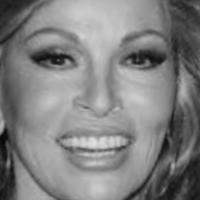

In [ ]:
faces[3500]

array([[  9,  14,  11, ...,  11,  13,  13],
       [  9,  10,   8, ...,  12,  13,  13],
       [  8,  10,   9, ...,  12,  12,  12],
       ...,
       [233, 233, 196, ...,  26,  18,  16],
       [205, 189, 170, ...,  28,  18,  18],
       [111,  96,  75, ...,  32,  21,  18]], dtype=uint8)
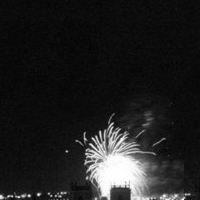

In [ ]:
nonfaces[4500]

In [ ]:
print(len(nonfaces))
print(len(faces))

16512
20060


Alcune delle immagini varie sono state saltate poichè possedevano una o entrambe le dimensioni minori di 200 pixel. Rimaniano così con 16500 immagini varie e 20000 immagini di facce. Il dataset risulta essere abbastanza bilanciato, possiamo procedere.

### <font color="yellow">***Feature Extraction con HOG***</font>

Cercando su internet uno dei modi migliori per effettuare analisi di face detection è quello dell'approccio HOG + SVM

(https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)

(In fondo al notebook ho eseguito alcuni test per capire il funzionamento di HOG, visto che non lo avevo mai usato)

Usiamo poi SVM (via LinearSVC) perché è l’approccio classico e ben collaudato per riconoscere pattern in spazi di feature ad alta dimensione (come quelli estratti da HOG), offre un buon compromesso tra accuratezza e velocità, e sfrutta il concetto di margine massimo per una separazione solida delle due classi.

Creo qui una funzione per andare a trasformare le immagini secondo l'algoritmo HOG ed estrarre quindi i gradienti e l'orientazione dei gradienti in ogni pixel.

Il numero di pixel per cella e celle per blocco sono due iperparametri che possono influire sulla accuratezza del modello, per il momento considero celle di dimensioni 8x8 e 2x2 celle per blocco

In [ ]:
# noto che il processo di estrazione delle hog features è molto dispendioso dal punto di vista computazionale,
# quindi procedo campionando casualmente solo un sottoinsieme delle due liste
 # (anche per evitare di avere troppi oggetti grossi in memoria e saturare la ram disponibile su colab)
new_faces    = random.sample(faces,    k=2000)
new_nonfaces = random.sample(nonfaces, k=2000)

In [ ]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for im in images:
        feat = hog(im,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys')
        features.append(feat)
    return np.array(features)


In [ ]:
# Estrazione HOG e creazione dataset feature e target
X_pos = extract_hog_features(new_faces, pixels_per_cell=(8,8), cells_per_block=(2,2))
X_neg = extract_hog_features(new_nonfaces, pixels_per_cell=(8,8), cells_per_block=(2,2))

y = np.hstack((np.ones(len(X_pos)), np.zeros(len(X_neg))))
X = np.vstack((X_pos, X_neg))

In [ ]:
print(X.shape)

(4000, 20736)


### <font color="yellow">***Creazione & Addestramento modello di classificazione SVC***</font>

In [ ]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

clf = LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)

LinearSVC(max_iter=10000)

In [ ]:
# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       404
         1.0       1.00      1.00      1.00       396

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Ok, sulle immagini di test abbiamo una accuratezza del 100% (inaspettatamente buono)

#### ***Salvo il modello creato***

In [ ]:
joblib.dump(clf, 'face_detector_svm.pkl')

['face_detector_svm.pkl']

A questo punto, una volta salvato il modello, riavvio manualmente il kernel per liberare lo spazio in ram e rilancio il codice per caricare le librerie

### <font color="yellow">***Creazione pipeline per rilevamento volti da qualsiasi immagine***</font>

Ora procedo con la creazione degli step necessari per rilevare un volto in una immagine qualunque usando il modello appena salvato

- Uso Image Pyramid: In questa maniera genero più versioni ridotte (o ingrandite) dell’immagine originale, applicando ripetuti fattori di scala, fino a raggiungere la dimensione minima della finestra di rilevamento (200×200), Così un volto piccolo nell’immagine originale sarà “ingrandito” in qualche livello della piramide, e uno grande verrà “ridotto”, consentendo di rilevare perfettamente qualsiasi taglia di viso (entro certi limiti).
- Applico Sliding Window: Questa fase mi permette di far scorrere una certa finestra sull'immagine passata in output dalla funzione Pyramid e verificare se in quella finestra è presente un volto
- HOG + SVC: per ogni finestra applico la trasformazione HOG e poi uso il modello che ho addestrato per classificare l'immagine
- Riscalo quindi l'immagine per trovare il corretto riquadro che identifica il volto
- Non maxima suppression: Applico infine un algoritmo di soppressione dei riquadri sovrapposti, scartando quelli con bassa confidenza o che si sovrappongono troppo, mantenendo una singola scatola per ogni volto rilevato (idealmente).

In [ ]:
# Detection pipeline (sliding window + image pyramid)
def pyramid(image, scale=1.25, min_size=(200, 200)):
    """
    Restituisce un generatore di immagini scalate:
    - image: immagine di partenza (grayscale)
    - scale: fattore di riduzione ad ogni passo (es. 1.25 → 80% della dimensione precedente)
    - min_size: dimensione minima per fermare la piramide
    """
    yield image
    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv2.resize(image, (w, h))
        if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
            break
        yield image

def sliding_window(image, step_size, window_size):
    """
    - image: livello corrente della piramide (grayscale)
    - step_size: spostamento in pixel tra una finestra e la successiva
    - window_size: (width, height) fissa, es. (200,200)
    """
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def non_max_suppression(boxes, overlap_thresh=0.3):
    # Implementazione non max suppresion per filtrare box sovrapposti
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = idxs[-1]
        i = last
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[idxs[:-1]]

        idxs = np.delete(idxs, np.concatenate(
            ([len(idxs) - 1], np.where(overlap > overlap_thresh)[0])))
    return boxes[pick].astype("int")

In [ ]:
# creazione funzione finale che esegui tutti i passaggi per la rilevazione del volto
def detect_faces(image_path, model_path='face_detector_svm.pkl',
                 win_size=(200,200), step_size=16):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clf = joblib.load(model_path)
    rects = []
    orig_w = gray.shape[1]

    for resized in pyramid(gray, scale=1.2, min_size=win_size):
        scale_factor = orig_w / float(resized.shape[1])
        feats, coords = [], []
        for (x, y, window) in sliding_window(resized, step_size, win_size):
            feats.append(hog(window,
                             pixels_per_cell=(8,8),
                             cells_per_block=(2,2),
                             block_norm='L2-Hys'))
            coords.append((x, y))
        if feats:
            preds = clf.predict(np.vstack(feats))
            for pred, (x, y) in zip(preds, coords):
                if pred == 1:
                    rx = int(x * scale_factor)
                    ry = int(y * scale_factor)
                    rw = int(win_size[0] * scale_factor)
                    rh = int(win_size[1] * scale_factor)
                    rects.append((rx, ry, rw, rh))

    final_boxes = non_max_suppression(rects)
    return final_boxes,rects

In [ ]:
# Esempio
boxes_1,rects_1 = detect_faces('foto test.jpg', model_path='face_detector_svm.pkl',
                 win_size=(200,200), step_size=16)

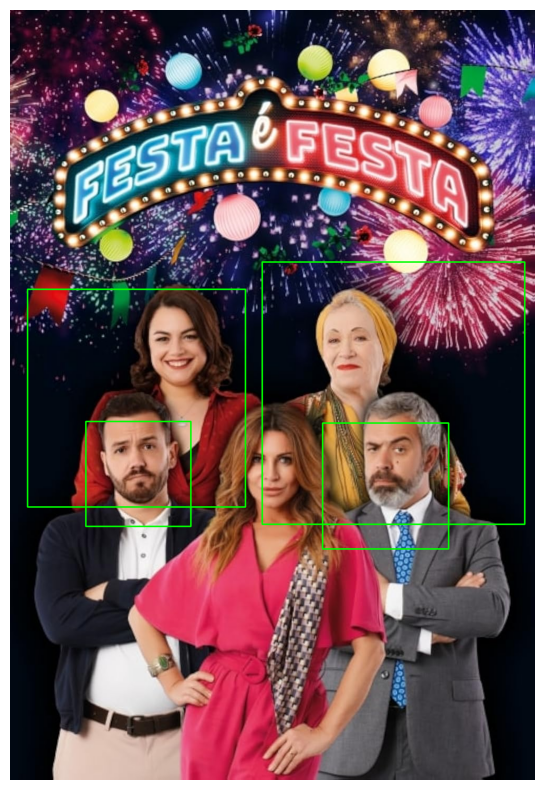

In [ ]:
# Visualizzazione dei risultati su immagine

img_path = 'foto test.jpg'
img = cv2.imread(img_path)
for (x, y, w, h) in boxes_1:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# Converti da BGR a RGB e mostra con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Esempio
boxes_2,rects_2 = detect_faces('foto test 2.jpg', model_path='face_detector_svm.pkl',
                 win_size=(200,200), step_size=16)

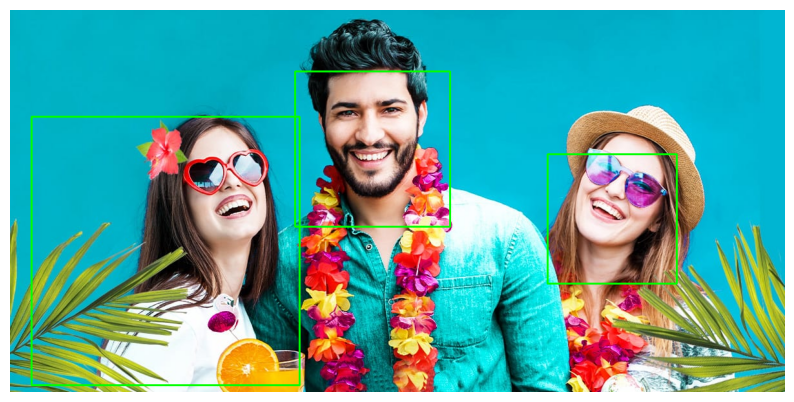

In [ ]:
# Visualizzazione dei risultati su immagine

img_path = 'foto test 2.jpg'
img = cv2.imread(img_path)
for (x, y, w, h) in boxes_2:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# Converti da BGR a RGB e mostra con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [ ]:
# Esempio
boxes_3,rects_3 = detect_faces('foto test 3.jpg', model_path='face_detector_svm.pkl',
                 win_size=(200,200), step_size=16)

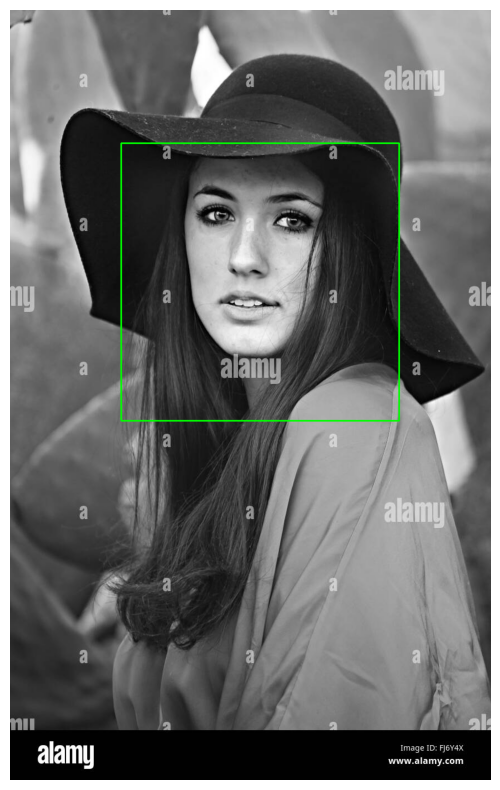

In [ ]:
# Visualizzazione dei risultati su immagine

img_path = 'foto test 3.jpg'
img = cv2.imread(img_path)
for (x, y, w, h) in boxes_3:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# Converti da BGR a RGB e mostra con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

Sulle foto di test il modello si comporta in maniera abbastanza decente, ho provato a fare un po' di esperimenti cambiando la dimensione delle celle per l'hog oppure modificando il numero di immagini per l'addestramento del modello, ma non riesco a ottenere un risultato migliore.

#### ***Reference***

https://www.geeksforgeeks.org/ml-implement-face-recognition-using-k-nn-with-scikit-learn/

https://en.wikipedia.org/wiki/Face_detection

https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

https://scikit-image.org/docs/stable/auto_examples/applications/plot_face_detection.html

# <font color="red">**Test su funzionamento dell'algoritmo HOG**</font>

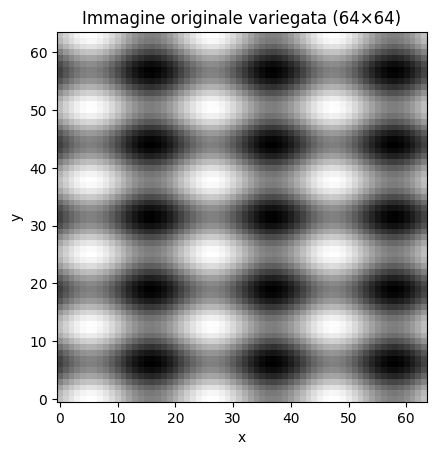

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# 1. Generazione immagine variegata (64×64)
x = np.linspace(0, 2 * np.pi, 64)
y = np.linspace(0, 2 * np.pi, 64)
X, Y = np.meshgrid(x, y)
image = (np.sin(3 * X) + np.cos(5 * Y)) * 127.5 + 127.5

# Plot immagine originale
plt.figure()
plt.title('Immagine originale variegata (64×64)')
plt.imshow(image, origin='lower', cmap='gray')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

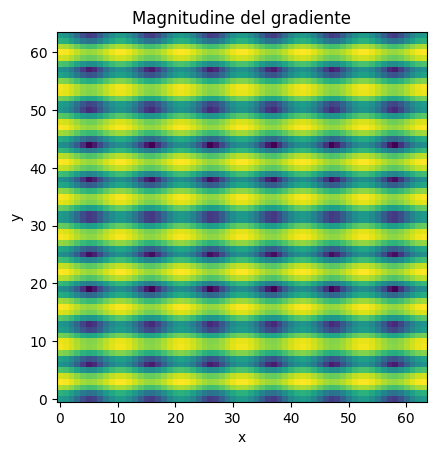

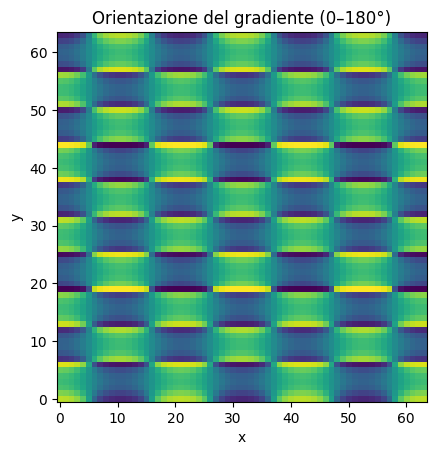

In [ ]:
# 2. Calcolo dei gradienti
gy, gx = np.gradient(image)
magnitude = np.hypot(gx, gy)
orientation = (np.degrees(np.arctan2(gy, gx)) + 180) % 180

# Plot magnitudine
plt.figure()
plt.title('Magnitudine del gradiente')
plt.imshow(magnitude, origin='lower')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

# Plot orientazione
plt.figure()
plt.title('Orientazione del gradiente (0–180°)')
plt.imshow(orientation, origin='lower')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

In [ ]:
orientation

array([[157.55197889, 156.61829305, 153.43318915, ..., 153.43318915,
        156.61829305, 157.55197889],
       [142.18891899, 140.92108157, 136.79633483, ..., 136.79633483,
        140.92108157, 142.18891899],
       [126.26697079, 125.03392345, 121.22423174, ..., 121.22423174,
        125.03392345, 126.26697079],
       ...,
       [ 53.73302921,  54.96607655,  58.77576826, ...,  58.77576826,
         54.96607655,  53.73302921],
       [ 37.81108101,  39.07891843,  43.20366517, ...,  43.20366517,
         39.07891843,  37.81108101],
       [ 22.44802111,  23.38170695,  26.56681085, ...,  26.56681085,
         23.38170695,  22.44802111]])

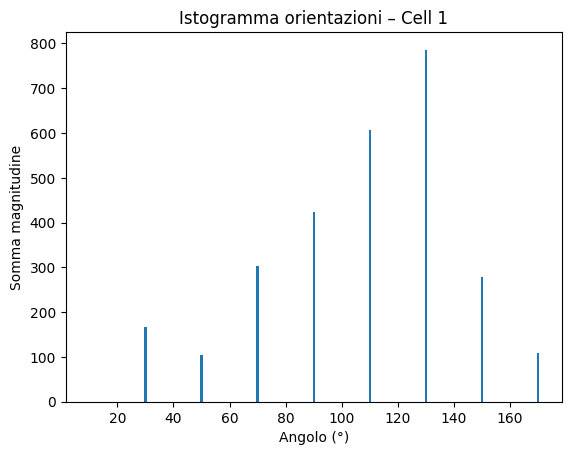

,Bin Center (°),Cell1 Count,Cell2 Count
0,10.0,0.000000,204.648246
1,30.0,167.162027,358.020612
2,50.0,103.380340,1169.067601
3,70.0,303.942123,817.042088
4,90.0,424.576863,169.486795
5,110.0,605.663483,22.469647
6,130.0,786.013364,28.072047
7,150.0,278.040716,233.867414
8,170.0,108.062136,0.000000


In [ ]:
# 3. Creazione delle cell (8×8) e istogrammi
cell_size = 8
bins = np.linspace(0, 180, 10)  # 9 bin da 20°

histograms = []
for i in range(2):  # due celle orizzontali
    cell_ori = orientation[0:cell_size, i*cell_size:(i+1)*cell_size]
    cell_mag = magnitude[0:cell_size, i*cell_size:(i+1)*cell_size]
    hist, _ = np.histogram(cell_ori, bins=bins, weights=cell_mag)
    histograms.append(hist)

# Istogramma della prima cell
plt.figure()
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.title('Istogramma orientazioni – Cell 1')
plt.bar(bin_centers, histograms[0])
plt.xlabel('Angolo (°)'); plt.ylabel('Somma magnitudine')
plt.show()

# Tabella dei valori di istogramma
df_hist = pd.DataFrame({
    'Bin Center (°)': bin_centers,
    'Cell1 Count': histograms[0],
    'Cell2 Count': histograms[1]
})
display(df_hist)

In [ ]:
# 4. Normalizzazione dei blocchi (2 celle per blocco)
raw_vector = np.concatenate(histograms)
norm = np.linalg.norm(raw_vector)
normalized_vector = raw_vector / norm if norm != 0 else raw_vector

# Tabella raw vs normalized
df_norm = pd.DataFrame({
    'Raw': raw_vector,
    'Normalized': normalized_vector
})
display(df_norm)

,Raw,Normalized
0,0.000000,0.000000
1,167.162027,0.087211
2,103.380340,0.053935
3,303.942123,0.158571
4,424.576863,0.221508
5,605.663483,0.315984
6,786.013364,0.410075
7,278.040716,0.145058
8,108.062136,0.056378
9,204.648246,0.106768


In [ ]:
# 5. Descriptor finale e dimensione
descriptor_length = len(normalized_vector)
print(f'Lunghezza del descrittore finale: {descriptor_length} elementi')


Lunghezza del descrittore finale: 18 elementi


In [ ]:
def detect_faces(image_path, model_path='face_detector_svm.pkl',
                 win_size=(200,200), step_size=16):
    # Carica immagine e modello
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clf = joblib.load(model_path)
    orig_w = gray.shape[1]
    detections = []

    # Per ogni livello di scala
    for resized in pyramid(gray, scale=1.2, min_size=win_size):
        scale_factor = orig_w / float(resized.shape[1])
        coords = []
        windows = []
        for (x, y, window) in sliding_window(resized, step_size, win_size):
            coords.append((x, y))
            windows.append(window)
        # Estrai HOG in parallelo
        feats = Parallel(n_jobs=-1)(
            delayed(_compute_hog)(w, pixels_per_cell=(8,8), cells_per_block=(2,2))
            for w in windows
        )
        if feats:
            # Batch prediction
            preds = clf.predict(np.vstack(feats))
            for pred, (x, y) in zip(preds, coords):
                if pred == 1:
                    rx = int(x * scale_factor)
                    ry = int(y * scale_factor)
                    rw = int(win_size[0] * scale_factor)
                    rh = int(win_size[1] * scale_factor)
                    detections.append((rx, ry, rw, rh))

    final_boxes = non_max_suppression(detections)
    return final_boxes,detections


In [ ]:
## hog parallelizzato
def _compute_hog(im, pixels_per_cell, cells_per_block):
    return hog(im,
               pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block,
               block_norm='L2-Hys')

def extract_hog_features(images,
                         pixels_per_cell=(8,8),
                         cells_per_block=(2,2),
                         n_jobs=-1):
    """
    Estrae HOG in parallelo usando joblib.Parallel.
    n_jobs: numero di processi (-1 = tutti i core disponibili).
    """
    feats = Parallel(n_jobs=n_jobs)(
        delayed(_compute_hog)(im, pixels_per_cell, cells_per_block)
        for im in images
    )
    return np.array(feats)